In [10]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pylab as plt
import math

In [11]:
from google.colab import drive
drive.mount('/content/drive')

address = "IP-HW4/"
import sys
sys.path.append('/content/drive/My Drive/{}'.format(address))

%cd /content/drive/My\ Drive/$address

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/IP-HW4


Here we load the image from the given path.

In [12]:
img = cv2.imread('./tasbih.jpg')
# img = cv2.resize(img, (int(img.shape[1]/10), int(img.shape[0]/10)))

In [13]:
img.shape

(828, 1104, 3)

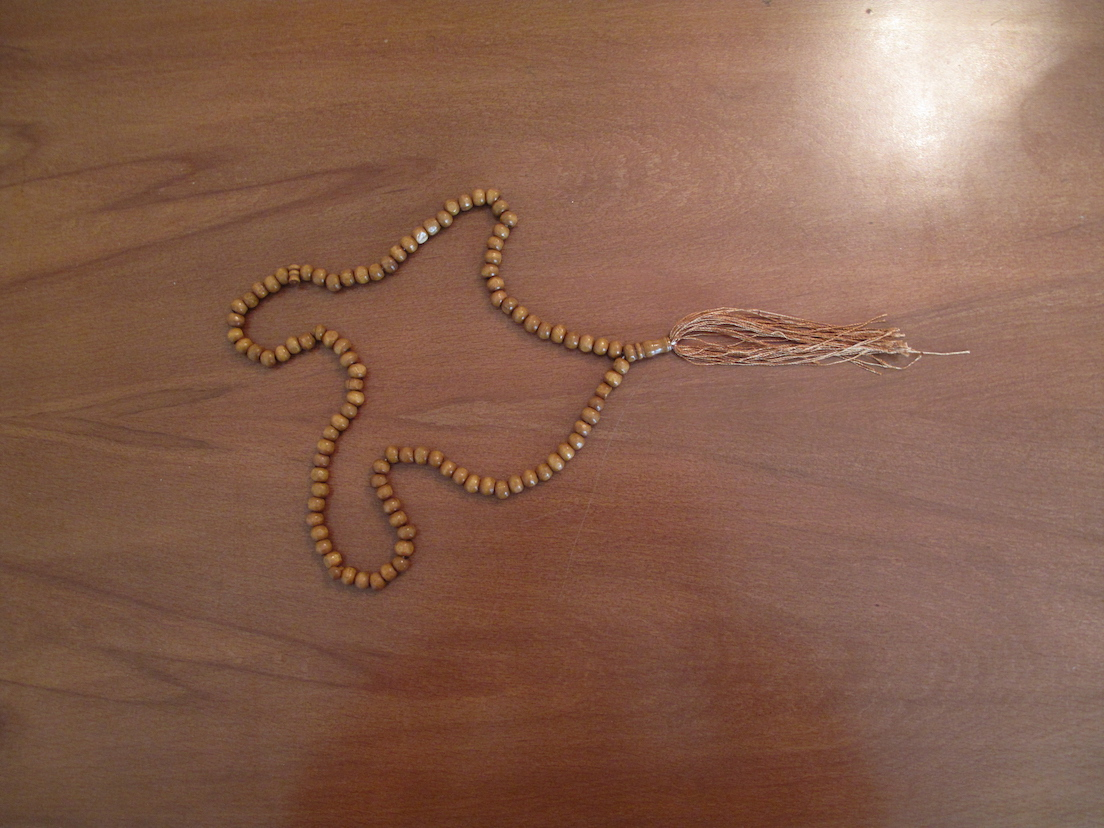

In [14]:
cv2_imshow(img)

Now we calculate gradient magnitude of the image. We also blur and filter the low intensities so that we can have a easier job in next parts.

In [15]:
ddepth = cv2.CV_32F
dx = cv2.Sobel(img, ddepth, 1, 0)
dy = cv2.Sobel(img, ddepth, 0, 1)
mag = (dx ** 2 + dy ** 2) ** 0.5
mag = cv2.cvtColor(mag, cv2.COLOR_BGR2GRAY)
mag = cv2.blur(mag, (11, 11))
mag[ mag < 60] = 0
mag = cv2.medianBlur(mag, 5)
mag = cv2.medianBlur(mag, 5)

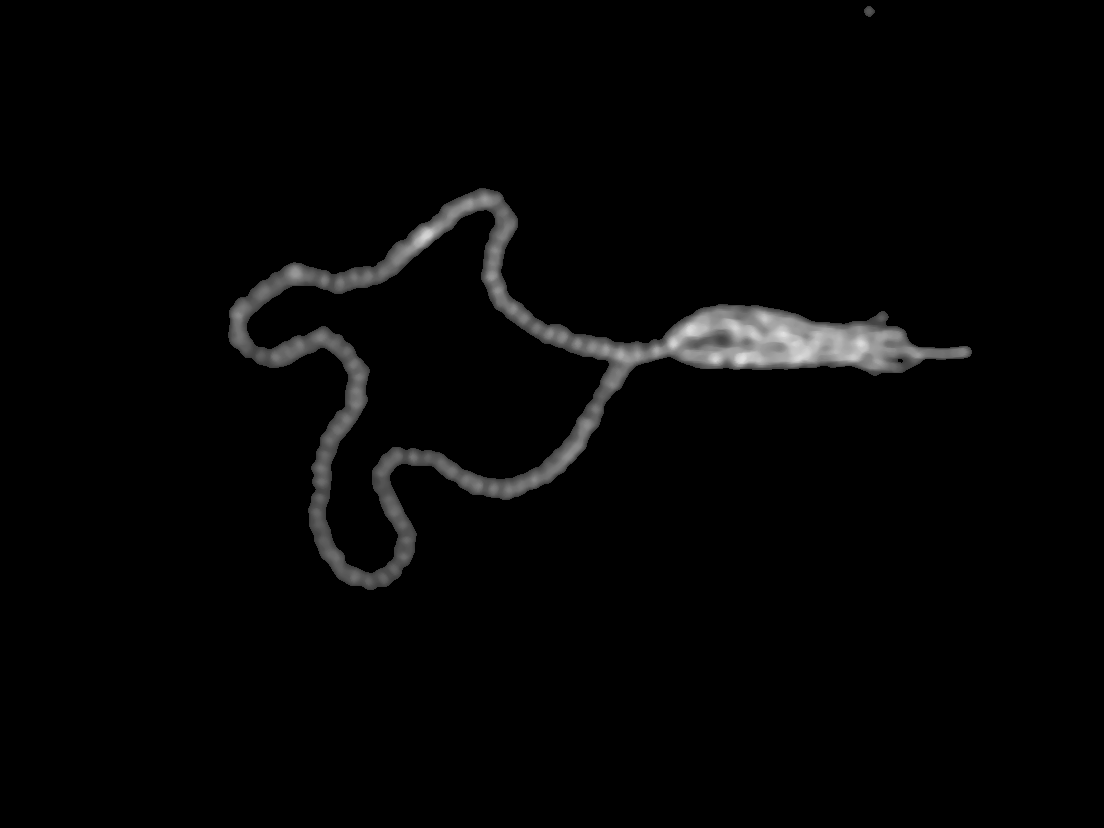

In [16]:
cv2_imshow(mag)

Here is 3d plot of negative of magnitude function.

(828, 1104) (828, 1104)


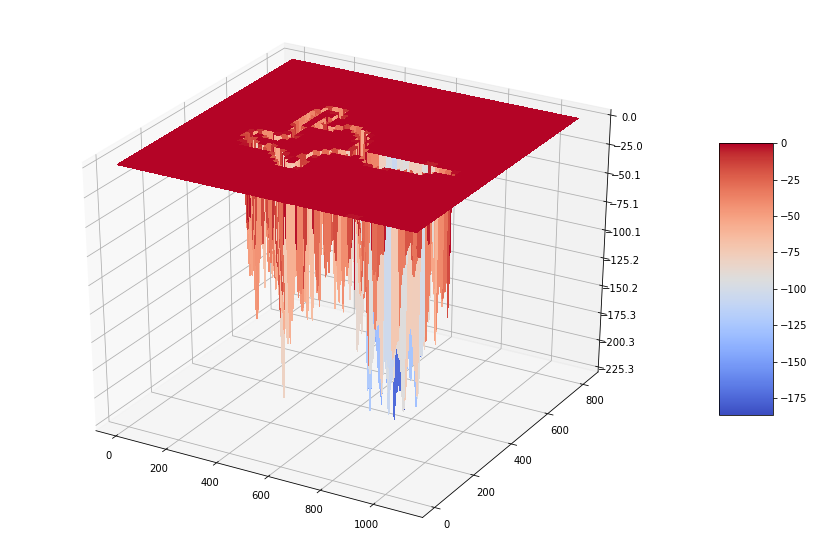

In [17]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15, 10))

# Make data.
X = np.arange(0, img.shape[1], 1).astype(np.uint16)
Y = np.arange(0, img.shape[0], 1).astype(np.uint16)
X, Y = np.meshgrid(X, Y)
print(X.shape, Y.shape)
# R = np.sqrt(X**2 + Y**2)
# Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, -mag, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-np.max(mag), -np.min(mag))
ax.zaxis.set_major_locator(LinearLocator(10))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Here we generate a set of initial points as the initial countour coordinates. Number of points are k=100. For selecting points on .py file we use gui. you click the points and it would draw the lines. Whenever you want to close the contour just double click.

In [18]:
k = 100

In [19]:
points = list()
center = np.array([380, 420])
def circle_points(r, n, c):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 2 * np.pi, n, endpoint=False)
        x = r * np.sin(t) + c[0]
        y = r * np.cos(t) + c[1]
        circles.append(np.c_[x, y])
    return circles

points = circle_points([230], [k], center)[0].astype(np.int16).tolist()

This is how it looks like

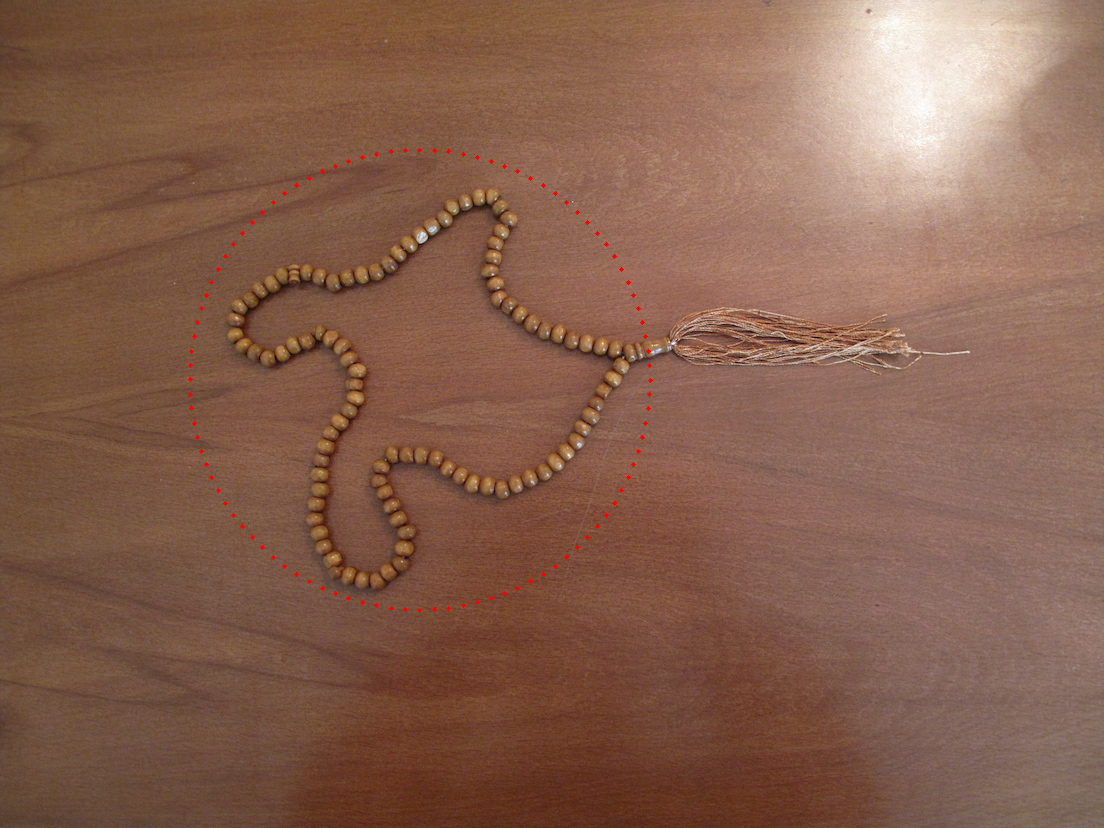

In [20]:
new_img = img.copy()
radius = 2
color = (0, 0, 255)
for point in points:
  new_img = cv2.circle(new_img, tuple(point)[::-1], radius, color, thickness=-1)

cv2_imshow(new_img)

This maps each coordinates to its all possible next values.

In [948]:
choices = {
    1: lambda x, y: (x-1, y-1),
    2: lambda x, y: (x-1, y),
    3: lambda x, y: (x-1, y+1),
    4: lambda x, y: (x, y-1),
    5: lambda x, y: (x, y),
    6: lambda x, y: (x, y+1),
    7: lambda x, y: (x+1, y-1),
    8: lambda x, y: (x+1, y),
    9: lambda x, y: (x+1, y+1)
}

This function takes an input and returns list of all next points.

In [949]:
def find_next_points(points):
  next= list()
  for point in points:
    next_points = list()
    for choice in choices.values():
      next_points.append(choice(*point))
    next.append(next_points)
  return np.array(next)

This functions calculates distance among contour points.

In [950]:
def calculate_average_distance(points):
  new_points = points.copy()
  new_points.append(points[0])
  p = np.array(new_points)
  x = p[:, 0]
  y = p[:, 1]
  x_distances = np.convolve(x, [1, -1], 'valid')
  y_distances = np.convolve(y, [1, -1], 'valid')
  total_distances = np.sum((x_distances ** 2 + y_distances ** 2) ** 0.5)
  return total_distances / (len(points))

def calculate_pair_distances(points):
  new_points = points.copy()
  new_points.append(points[0])
  p = np.array(new_points)
  x = p[:, 0]
  y = p[:, 1]
  x_distances = np.convolve(x, [1, -1], 'valid')
  y_distances = np.convolve(y, [1, -1], 'valid')
  total_distances = (x_distances ** 2 + y_distances ** 2) ** 0.5
  return total_distances

Here is the viterbi algorithm. it uses both internal and external enrgy. It supports both first derivitive and scond derivitive. It has also an extra parameter called distance from center.

The thing that what each term does has discussed in the class but the extra term distance from center is for makind the contour to converge.

E internal = alpha * E first derivitive + E second derivitve + beta * distacnce from mean of points

E external = gama * gradient magnitude

In [1236]:
def calculate_distance(p1, p2, d):
  return (np.sum((np.array(p1)-np.array(p2)) ** 2, axis=-1) ** 0.5 - d) ** 2

def calculate_second_order_distance(p1, p2, p3):
  return np.sum((np.array(p1)-2 *np.array(p2) + np.array(p3)), axis=-1) ** 2

def viterbi(source, points, current_points, G, d, alpha=0.1, beta=0.05 ,gama=0.1):
  points = np.array(points)[1:]
  score = np.zeros(shape=(points.shape[0] + 1, 9), dtype=np.float64)
  path = np.zeros(shape=(points.shape[0] + 1, 9))
  cols = points.shape[0]
  center = np.mean(np.array(current_points), axis=0)
  
  vectorized_distances = ((current_points - np.array(center))**2).reshape(-1, 2)

  avg_distance = np.mean(np.sum(vectorized_distances, axis=-1)**0.5,)
  
  mean = center
  cov = [[5 * d, 0], [0, 5 * d]]
  center = np.random.multivariate_normal(mean, cov, 1)
  theta = 1 / avg_distance
  c = 1

  for i in range(9):
    score[0, i] = alpha * calculate_distance(source, points[0, i], d) \
                  - gama * G[points[0, i][0], points[0, i][1]]\
                  + theta * beta * np.sum((np.array(points[0, i])-center)**2) \
                  + c * calculate_second_order_distance(points[-1, 4], source, points[0,i])
      
  for j in range(9):
    new_scores = np.zeros(shape=(9,))
    for k in range(9):
      new_scores[k] = alpha * calculate_distance(points[0, k], points[1, j], d) + score[0, k] + c * calculate_second_order_distance(source, points[0, k], points[1, j])

    min_score = np.min(new_scores)
    min_index = np.argmin(new_scores)
    score[1, j] = min_score - gama * G[points[1, j][0], points[1, j][1]] + theta * beta * np.sum((np.array(points[1, j])-center)**2) 
    path[1, j] = min_index

  
  for i in range(2, cols):
    for j in range(9):
      new_scores = np.zeros(shape=(9,))
      for k in range(9):
        new_scores[k] = alpha * calculate_distance(points[i-1, k], points[i, j], d) + score[i-1, k] + c * calculate_second_order_distance(points[i-2, int(path[i-1, k])], points[i-1, k], points[i, j])

      min_score = np.min(new_scores)
      min_index = np.argmin(new_scores)
      score[i, j] = min_score - theta * gama * G[points[i, j][0], points[i, j][1]] + theta * beta * np.sum((np.array(points[i, j])-center)**2) 
      path[i, j] = min_index

  new_scores = np.zeros(shape=(9,))
  for i in range(9):
    new_scores[i] = alpha * calculate_distance(points[-1, i], source,d) + score[-2, i] + c * calculate_second_order_distance(points[-2, int(path[-2, i])], points[-1, i], source)
  min_score = np.min(new_scores)
  min_index = np.argmin(new_scores)
  
  for i in range(9):
    score[-1, i] = min_score - theta * gama * G[source[0], source[1]] + theta *  beta * np.sum((np.array(source)-center)**2) 
    path[-1 ,i] = min_index

  return score, path

This backtracks the path generated by viterbi.

In [953]:
def backtrace_path(path_matrix):
  path = list()
  previous_point = path_matrix[-1, 0]
  path.append(previous_point)
  for i in range(path_matrix.shape[0] - 2, 0, -1):
    previous_point = path_matrix[i, int(previous_point)]
    path.append(previous_point)
  return path

This calls viterbi and receives score and paths of all optimal choices.

In [954]:
def find_internal_paths(points, next, G, d, alpha, beta ,gama):
  scores = np.zeros(shape=(9,), dtype=np.float64)
  paths = {}
  for i in range(9):
      score, path = viterbi(next[0, i], next, points, G, d, alpha, beta ,gama)
      scores[i] = score[-1, 0]
      path = backtrace_path(path)
      path.append(i)
      paths[i+1] = path[::-1]
  return scores, paths

def update_contour(path, points):
  new_points = list()
  for i, p in enumerate(path):
    new_points.append(choices[p+1](*points[i]))
  return new_points

It's the main function that minimizes enrgy.

In [955]:
def minimize_energy(points, next, G, d, alpha=0.5, beta=1, gama=0.1):
  e_total, p = find_internal_paths(points, next, G, d, alpha, beta ,gama)
  ind = np.argmin(e_total)
  return update_contour(p[ind+1], points)

This is the part that iterates over and narrows down the contour

In [1237]:
difference = float('inf')
# points_2 = points.copy()
points_2 = points.copy()
steps = []
while difference > 0:
  d = calculate_average_distance(points_2)
  next = find_next_points(points_2)
  new_points = minimize_energy(points_2, next, mag, d, alpha=1, beta=2, gama=1e3)
  difference = np.sum((np.array(new_points)-np.array(points_2))**2)
  steps.append(new_points)
  points_2 = new_points
  # if you comment it out the algorithm updates its number of points
  # for index in zip(*np.where(np.abs(calculate_pair_distances(points_2)) > 2 * d)):
  #   points_2.insert((index[0]+1) % len(new_points), np.round((np.array(points_2[index[0]]) + np.array(points_2[(index[0]+1) % len(new_points)]))/2).astype(np.uint16).tolist())
  # new_points = points_2

Here we plot the image and add them as a sequence to images list.

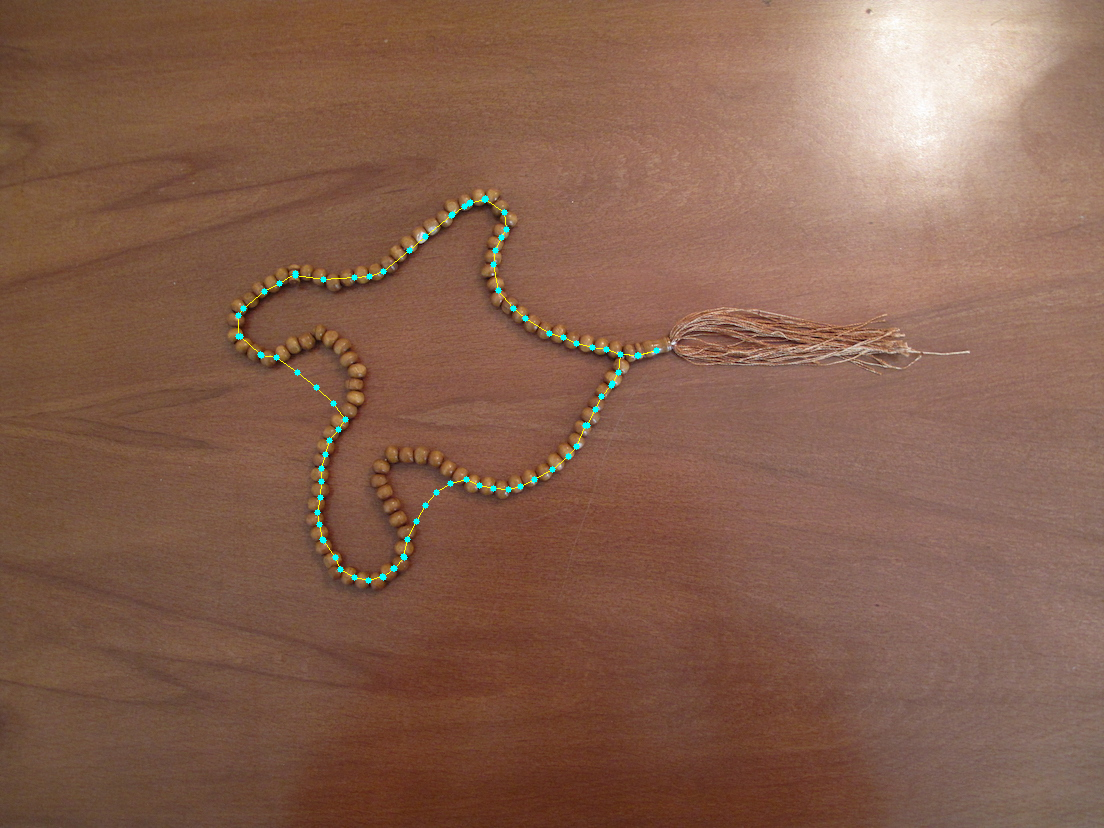

In [1240]:
import imageio

images = []


radius = 3
color = (255, 255, 0)

for step in steps:
  new_img = img.copy()
  for i in range(len(step)):
    new_img = cv2.line(new_img, tuple(step[i])[::-1],  tuple(step[(i+1) % len(step)])[::-1], color[::-1])


  for point in step:
    new_img = cv2.circle(new_img, tuple(point)[::-1], radius, color, thickness=-1)
  
  images.append(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))


cv2_imshow(new_img)

Finally we save it as a video.

In [ ]:
imageio.mimsave('./contour.mp4', images) # modify duration